In [10]:
import cv2
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops

import numpy as np
from matplotlib import pyplot as plt

import mbb

In [2]:
#test image
image_ffn = '/data/hailpixel_20200119/testing_subset/0328.png'

pixel_gsd = 2.6 #pixel ground sample distance in mm

inital_threshold = 0.7 #lightness threshold to use for masking
localmax_mindist = 2 #minimum distance in pixel units between hail centroids
min_area_mm = 3.14*(5**2) #minimum area of hailstone in pixels
min_area = int(min_area_mm/pixel_gsd**2) #minimum area in mm

In [32]:
#transform into hsv colorspace
img_data = cv2.imread(image_ffn)
img_data_hls = cv2.cvtColor(img_data, cv2.COLOR_BGR2HLS)

l_data = img_data_hls[:,:,1]/255
#apply inital threshold
l_mask = l_data > inital_threshold
#compute distance transform to find centroids
l_mask_dist = ndimage.distance_transform_edt(l_mask)
localMax = peak_local_max(l_mask_dist, indices=False, min_distance=localmax_mindist,
	labels=l_mask)

#run watershed
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-l_mask_dist, markers, mask=l_mask,watershed_line=True)

#remove small regions
region_prop_list = regionprops(labels)
#build centroid list
hail_centroid_x = []
hail_centroid_y = []
hail_major = []
hail_minor = []

for region_prop in region_prop_list:
    if region_prop.area > min_area:
        label_centroid = region_prop.centroid
        hail_centroid_x.append(label_centroid[1])
        hail_centroid_y.append(label_centroid[0])
        
        hail_pts_i, hail_pts_j = np.where(labels == region_prop.label)
        bounding_box = mbb.MinimumBoundingBox(list(zip(hail_pts_i,hail_pts_j)))
        
        len_parallel = bounding_box.length_parallel
        len_orthogonal = bounding_box.length_orthogonal
        
        #work out maj/min axis length
        if len_parallel>len_orthogonal:
            maj_axis_len, min_axis_len = len_parallel, len_orthogonal
        else:
            maj_axis_len, min_axis_len = len_orthogonal, len_parallel
        
        hail_major.append(maj_axis_len)
        hail_minor.append(min_axis_len)
        
hail_centroid_idx = list(range(len(hail_centroid_x)))

        
np.savez('test-detection.npz',hail_cx=hail_centroid_x,hail_cy=hail_centroid_y, hail_idx=hail_centroid_idx)

In [ ]:
#full plot
fig, axes = plt.subplots(nrows=3, ncols=2, facecolor='white',figsize=[30, 45])

im = axes[0,0].imshow(l_data, vmin=0, vmax=1)
im = axes[0,1].imshow(l_mask, vmin=0, vmax=1)
im = axes[1,0].imshow(l_mask_dist)
im = axes[1,1].imshow(localMax)
im = axes[2,0].imshow(labels)
im = axes[2,1].imshow(img_data[:,:,::-1]) #invert colours # RGB-> BGR
axes[2,1].plot(hail_centroid_x, hail_centroid_y, 'k.')

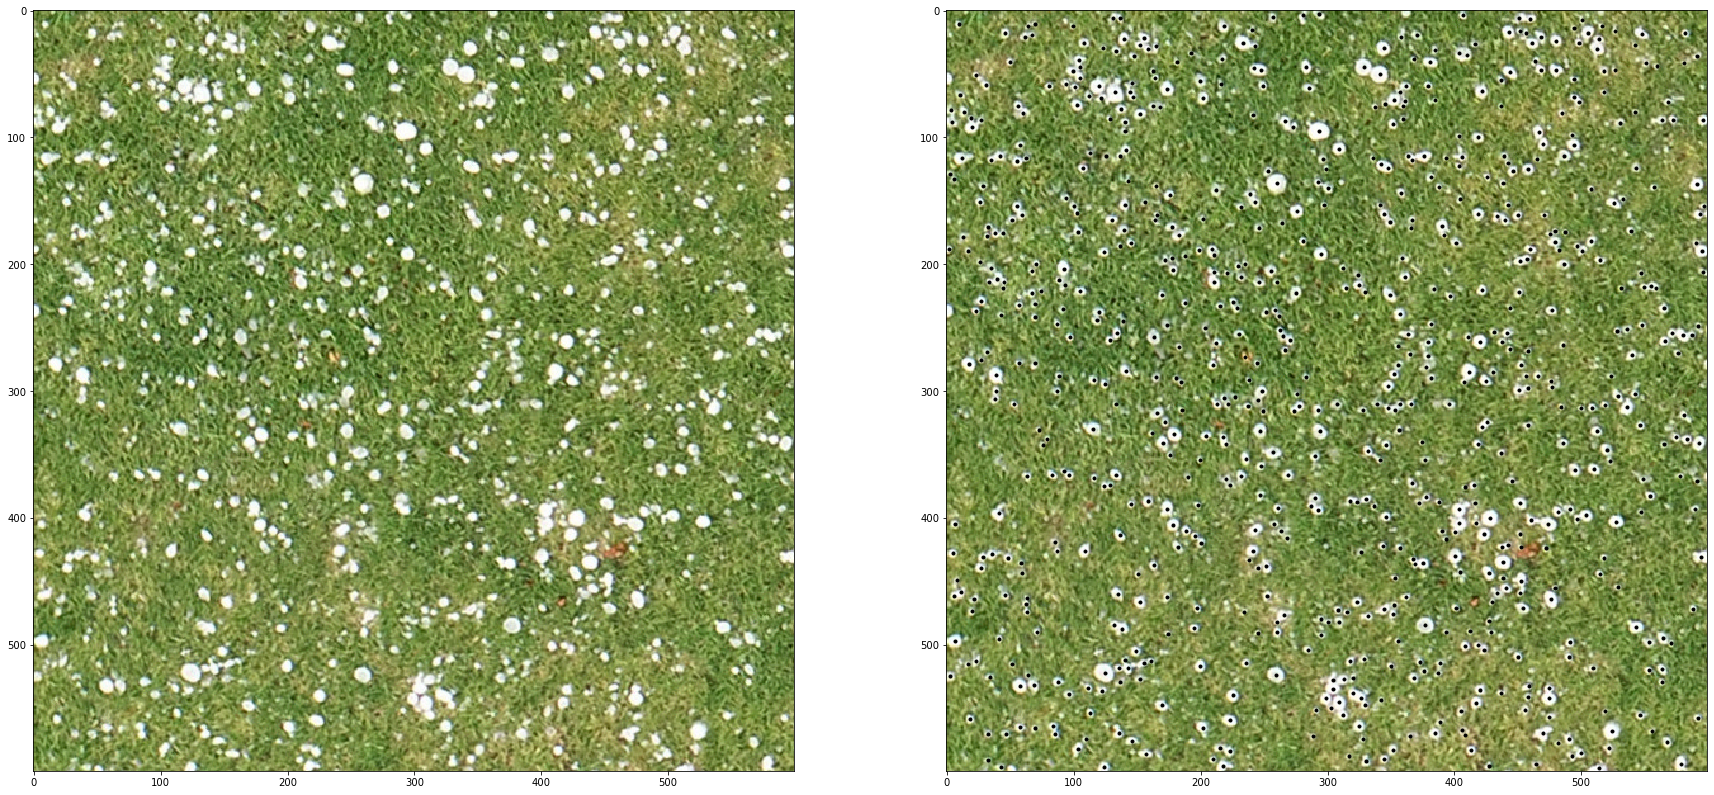

In [71]:
#simple plot
fig, axes = plt.subplots(nrows=1, ncols=2, facecolor='white',figsize=[30, 15])
im = axes[0].imshow(img_data[:,:,::-1]) #invert colours # RGB-> BGR
im = axes[1].imshow(img_data[:,:,::-1]) #invert colours # RGB-> BGR
axes[1].plot(hail_centroid_x, hail_centroid_y, 'k.')
        

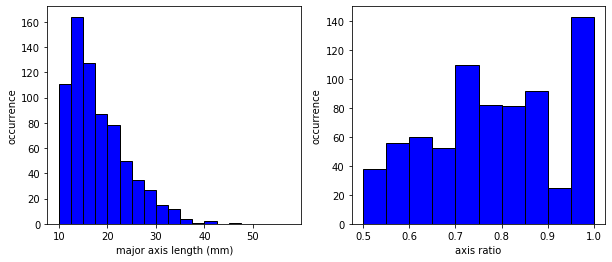

In [31]:
#plot distributions
def plot_stats(hail_maj, hail_min):
    pixel_scaling = 2.6 #mm/pixel
    
    #apply scaling
    hail_maj = hail_maj*pixel_scaling
    hail_min = hail_min*pixel_scaling
    
    # matplotlib histogram
    fig = plt.figure(facecolor='white',figsize=[10, 4])

    plt.subplot(1, 2, 1)
    plt.hist(hail_maj, color = 'blue', edgecolor = 'black', bins=np.arange(10,60,2.5))
    plt.xlabel('major axis length (mm)')
    plt.ylabel('occurrence')

    plt.subplot(1, 2, 2)
    plt.hist(hail_min/hail_maj, color = 'blue', edgecolor = 'black', bins=np.arange(0.5,1.05,0.05))
    plt.xlabel('axis ratio')
    plt.ylabel('occurrence')


hail_major_array = np.array(hail_major)
hail_minor_array = np.array(hail_minor)

plot_stats(hail_major_array, hail_minor_array)